In [ ]:
!pip install datasets
!pip install transformers

In [ ]:
import os
import requests
from collections import OrderedDict

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from transformers import AdamW, get_scheduler, DistilBertModel, DistilBertConfig, DistilBertTokenizerFast

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#loads only backbone weights
os.environ['KAGGLE_CONFIG_DIR'] = './'
!kaggle datasets download -d muniozdaniel0/final-distilbert-weight
!unzip ./final-distilbert-weight.zip -d ./final-distilbert-weight
!rm ./final-distilbert-weight.zip

In [ ]:
#loading backbone checkpoint ----may be a good idea to change it to 'backbone_checkpoint'
checkpoint = torch.load('./final-distilbert-weight/distilbert_reddit_epoch_2_iter_final.pt', map_location=device)
checkpoint['model'] = OrderedDict({k[11:]: v for k, v in checkpoint['model'].items() if 'distilbert' in k})  #OrderedDict to keep it consistant with pytorch

###Utils

In [ ]:
##sst-2 regresor
def tokenizer_map(element):
  return tokenizer(element['sentence'], max_length=tokenizer.model_max_length, truncation=True)

class Data_collator():
  def __init__(self, tokenizer): 
    self.tokenizer = tokenizer

  def __call__(self, batch):
    #Assumes we are wotking with a list of dictionaries
    training_dict = {'input_ids': [element['input_ids'] for element in batch], 
                     'attention_mask': [element['attention_mask'] for element in batch]}
    training_samples = self.tokenizer.pad(training_dict, return_tensors = 'pt')
    labels = torch.tensor([element['label'] for element in batch], dtype=torch.float32)

    return {'input_ids': training_samples['input_ids'],
            'attention_mask': training_samples['attention_mask'],
            'labels': labels}

In [ ]:
##sst-2 binary
def tokenizer_map_df(element):
  #sst-2 tokenizer_df
  tokenized_elemen = tokenizer(element['sentence'], max_length=tokenizer.model_max_length, truncation=True)
  return element.append(pd.Series([tokenized_elemen['input_ids'], tokenized_elemen['attention_mask']], index=['input_ids', 'attention_mask']))
  
class Data_collator():
  def __init__(self, tokenizer): 
    self.tokenizer = tokenizer

  def __call__(self, batch):
    #Assumes we are wotking with a list of dictionaries
    training_dict = {'input_ids': [element['input_ids'] for element in batch], 
                     'attention_mask': [element['attention_mask'] for element in batch]}
    training_samples = self.tokenizer.pad(training_dict, return_tensors = 'pt')
    labels = torch.tensor([element['label'] for element in batch], dtype=torch.float32)

    return {'input_ids': training_samples['input_ids'],
            'attention_mask': training_samples['attention_mask'],
            'labels': labels}

In [ ]:
##financial phrasebank
def tokenizer_map_df(element):
  #sst-2 tokenizer_df
  tokenized_elemen = tokenizer(element['sentence'], max_length=tokenizer.model_max_length, truncation=True)
  return element.append(pd.Series([tokenized_elemen['input_ids'], tokenized_elemen['attention_mask']], index=['input_ids', 'attention_mask']))

class Data_collator():
  def __init__(self, tokenizer): 
    self.tokenizer = tokenizer

  def __call__(self, batch):
    #Assumes we are wotking with a list of dictionaries
    training_dict = {'input_ids': [element['input_ids'] for element in batch], 
                     'attention_mask': [element['attention_mask'] for element in batch]}
    training_samples = self.tokenizer.pad(training_dict, return_tensors = 'pt')
    labels = torch.tensor([element['label'] for element in batch], dtype=torch.float32)

    return {'input_ids': training_samples['input_ids'],
            'attention_mask': training_samples['attention_mask'],
            'labels': labels}

In [ ]:
##sentiment 140
#### -----current version
class tokenizer_map_df():
  def __init__(self, tokenizer, column_name=None):
    self.tokenizer = tokenizer
    self.column_name = column_name
  
  def __call__(self, element):
    if not self.column_name:
      tokenized_elemen = tokenizer(element['sentence'], max_length=tokenizer.model_max_length, truncation=True)
    else:
      tokenized_elemen = tokenizer(element[self.column_name], max_length=tokenizer.model_max_length, truncation=True)

    return element.append(pd.Series([tokenized_elemen['input_ids'], tokenized_elemen['attention_mask']], index=['input_ids', 'attention_mask']))

### -----reads array_strings as arrays
def str2arrray(elemen):
  return np.fromstring(elemen[1:-1], sep=',', dtype=np.int64)
  

### -----current version
class Data_collator():
  #List of dictionaries version
  def __init__(self, tokenizer): 
    self.tokenizer = tokenizer

  def __call__(self, batch):
    training_dict = {'input_ids': [element['input_ids'] for element in batch], 
                     'attention_mask': [element['attention_mask'] for element in batch]}
    training_samples = self.tokenizer.pad(training_dict, return_tensors = 'pt')
    labels = torch.tensor([element['label'] for element in batch], dtype=torch.float32)

    return {'input_ids': training_samples['input_ids'],
            'attention_mask': training_samples['attention_mask'],
            'labels': labels}

###Datasets

In [ ]:
class sst_binary_dataset(Dataset):
  def __init__(self, dataframe):
    self.df = dataframe

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    return {'input_ids': self.df.iloc[idx]['input_ids'], 
            'attention_mask': self.df.iloc[idx]['attention_mask'],
            'label': self.df.iloc[idx]['label']}

In [ ]:
class fp_dataset(Dataset):
  def __init__(self, dataframe):
    self.df = dataframe

  def __len__(self):
    return len(self.df)
    
  def __getitem__(self, idx): 
    return {'input_ids': self.df['input_ids'].iloc[idx],
            'attention_mask': self.df['attention_mask'].iloc[idx],
            'label': self.df['label'].iloc[idx]}

In [ ]:
class Sentiment140(Dataset):
  def __init__(self, dataframe):
    self.df = dataframe

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    return {'input_ids': self.df['input_ids'].iloc[idx],
            'attention_mask': self.df['attention_mask'].iloc[idx],
            'label': self.df['label'].iloc[idx]}

In [ ]:
class df_dataset(Dataset):
  def __init__(self, dataframe, label_name=None):
    """
    Initializes a torch.dataset from a dataframe that contains the columns: 'input_ids', 'attention_mask', 'label'

    Args:
      dataframe: A pandas dataframe
    """
    self.df = dataframe
  
  def __len__(self):
    return len(self.df)
  
  def __getitem(self, idx):
    return {'input_ids': self.df['input_ids'].iloc[idx],
            'attention_mask': self.df['attention_mask'].iloc[idx],
            'label': self.df[label_name].iloc[idx] if label_name else self.df['label'].iloc[idx]}

###Models

In [ ]:
class DistilBertRegressor(nn.Module):
  def __init__(self, backbone_weights=None, freeze_backbone=False):
    super().__init__()  
    self.backbone = DistilBertModel(config=DistilBertConfig())
    
    if backbone_weights:
      self.backbone.load_state_dict(backbone_weights)
      print('backbone weights loaded succesfully')
    if freeze_backbone:
      for param in self.backbone.parameters():
        param.requires_grad = False

    self.linear =  nn.Linear(self.backbone.config.dim, self.backbone.config.dim)  #'backbone.config.dim' stores the output dimension of the backbone
    self.dropout = nn.Dropout(0.2)
    self.regressor = nn.Linear(self.backbone.config.dim, 1)
  
  #Could be useful to meassure differences? one model using the first layer of a pretrained classifier vs one being randomly initialized.
  def forward(self, input_ids, attention_mask, return_hidden_embeddings=False):
    hidden_embeddings = self.backbone(input_ids=input_ids, attention_mask=attention_mask)[0]
    out = self.linear(hidden_embeddings[:, 0, :])
    out = F.relu(out)
    out = self.dropout(out)
    out = self.regressor(out)

    if not return_hidden_embeddings:
      return out
    else:
      return hidden_embeddings, out

In [ ]:
#### ---Current Classifier Version---
class DistilBertClassifier(nn.Module):
  def __init__(self, out_dim=2, backbone_weights=None, freeze_backbone=False):
    super().__init__()  
    self.backbone = DistilBertModel(config=DistilBertConfig())
    
    if backbone_weights:
      self.backbone.load_state_dict(backbone_weights)
      print('backbone weights loaded succesfully')
    if freeze_backbone:
      for param in self.backbone.parameters():
        param.requires_grad = False

    self.linear =  nn.Linear(self.backbone.config.dim, self.backbone.config.dim)  #'backbone.config.dim' stores the output dimension of the backbone
    self.dropout = nn.Dropout(0.2)
    self.classifier = nn.Linear(self.backbone.config.dim, out_dim)
  
  def forward(self, input_ids, attention_mask, return_hidden_embeddings=False):
    hidden_embeddings = self.backbone(input_ids=input_ids, attention_mask=attention_mask)[0]
    out = self.linear(hidden_embeddings[:, 0, :])
    out = F.relu(out)
    out = self.dropout(out)
    out = self.classifier(out)

    if not return_hidden_embeddings:
      return out
    else:
      return hidden_embeddings, out

###sst-2 Regressor

In [ ]:
#defining tokenizer and DataCollator
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')                    #using ver. 4.10.0.dev0
collate_fn = Data_collator(tokenizer)

#load sst-2 dataset
sst_dataset = load_dataset("sst", "default")

tokenized_sst_dataset = sst_dataset.map(tokenizer_map, remove_columns=['sentence', 'tokens', 'tree'], batched=True)
sst_train_loader = DataLoader(tokenized_sst_dataset['train'], shuffle=True, batch_size=16, collate_fn=collate_fn)

In [ ]:
#Initializing model
#model = DistilBertRegressor(backbone_weights=checkpoint['model']).to(device)
model = DistilBertRegressor(backbone_weights=checkpoint['model'], freeze_backbone=True).to(device)

#defining loss and optimizer
optim = AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

num_epochs = 3

num_training_steps = num_epochs * len(sst_train_loader)
lr_scheduler = get_scheduler('linear', optimizer=optim, num_warmup_steps=600, num_training_steps=num_training_steps)

In [ ]:
model.train()
for epoch in range(num_epochs):
  for i, batch in enumerate(sst_train_loader):
    input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
    optim.zero_grad()

    out = model(input_ids, attention_mask, return_hidden_embeddings=False)
    
    #we may need to average the loss over the whole epoch
    loss = loss_fn(out.squeeze(), labels)
    loss.backward()
    optim.step()
    lr_scheduler.step()
    if i!=0 and i%200 == 0:
      print('saving model at iter{}'.format(i))
      
      torch.save({'epoch': epoch,
                  'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optim.state_dict(),
                  'lr_scheduler':lr_scheduler.state_dict(),
                  'local_loss':loss.item()},
                  './Distilbert_reddit_sst_weights_frozenbackbone/Distilbert_reddit_sst_epoch_{}_iter_{}.pt'.format(epoch, i))
    if i!=0 and i%100==0:
      print('epoch: {} iter: {} loss: {}'.format(epoch, i, loss.item()))

  print('storing "end of the epoch" weights')
  torch.save({'epoch': epoch,
              'model_state_dict':model.state_dict(),
              'optimizer_state_dict':optim.state_dict(),
              'lr_scheduler':lr_scheduler.state_dict(),
              'local_loss':loss.item()},
              './Distilbert_reddit_sst_weights_frozenbackbone/Distilbert_reddit_sst_epoch_{}.pt'.format(epoch))

####Regressor Testing

In [ ]:
#loading weights
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d muniozdaniel0/distilbert-reddit-sst-weights-frozenbackbone-2
!unzip ./distilbert-reddit-sst-weights-frozenbackbone-2.zip -d ./distilbert-reddit-sst-weights-frozenbackbone-2
!rm ./distilbert-reddit-sst-weights-frozenbackbone-2.zip

In [ ]:
#regressor values test
#loading sst_frozen checkpoint
sst_frozen_checkpoint = torch.load('./distilbert-reddit-sst-weights-frozenbackbone-2/Distilbert_reddit_sst_epoch_2.pt', map_location=device)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')                    #using ver. 4.10.0.dev0

#loading model
model = DistilBertRegressor().to(device)
model.load_state_dict(sst_frozen_checkpoint['model_state_dict'])
model.eval()

In [ ]:
#load dataset
sst_dataset = load_dataset("sst", "default")
tokenized_sst_dataset = sst_dataset.map(tokenizer_map, remove_columns=['sentence', 'tokens', 'tree'], batched=True)

collate_fn = Data_collator(tokenizer)
sst_test_loader = DataLoader(tokenized_sst_dataset['test'], shuffle=False, batch_size=16, collate_fn=collate_fn)

In [ ]:
with torch.no_grad():
  cumulative_loss = 0.0
  out_values = torch.tensor([])
  labels_values = torch.Tensor([])
  for _, batch in enumerate(sst_test_loader):
    out = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
    local_loss = nn.MSELoss()(out.view(-1), batch['labels'])
  
    cumulative_loss+=local_loss
    out_values = torch.cat((out_values, out.view(-1)))
    labels_values = torch.cat((labels_values, batch['labels']))

    print(local_loss, out.shape)
  global_eval_loss = cumulative_loss/len(sst_test_loader)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

dummy_y = np.zeros_like(out_values.numpy())
out_values.min(), out_values.max()

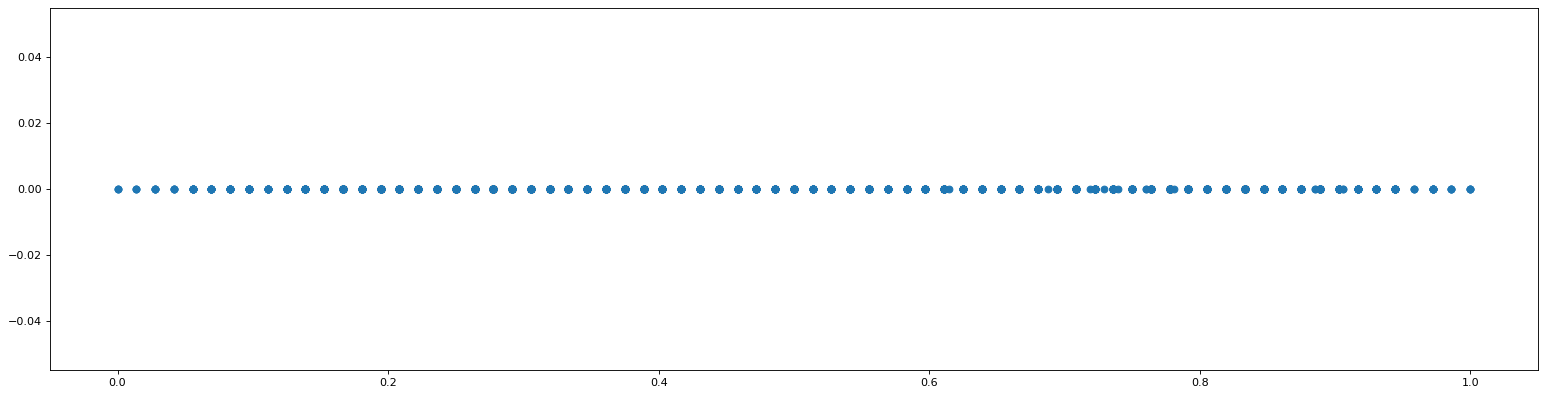

In [ ]:
figure(figsize=(24, 6), dpi=80)
plt.scatter(labels_values.numpy(), dummy_y)

###sst-2 binary

In [ ]:
import os
import pandas as pd
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
#downloading binary sst-2
data_dir = tf.keras.utils.get_file(
    fname='SST-2.zip', 
    origin='https://dl.fbaipublicfiles.com/glue/data/SST-2.zip',
    extract=True)
data_dir = os.path.splitext(data_dir)[0]

In [ ]:
#defining tokenizer and dcollator
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased') #using ver. 4.10.0.dev0
collate_fn = Data_collator(tokenizer)

#loading dataframes
train_df = pd.read_csv(os.path.join(data_dir, 'train.tsv'), sep='\t')
dev_df = pd.read_csv(os.path.join(data_dir, 'dev.tsv'), sep='\t')
test_df = pd.read_csv(os.path.join(data_dir, 'test.tsv'), sep='\t')

#tokenizing data ---only train data
tokenized_train_df = train_df.apply(tokenizer_map_df, axis=1)
tokenized_train_df = tokenized_train_df[['sentence', 'input_ids', 'attention_mask', 'label']]  #changing columns order

#dataset and dataloader ---only train data
train_dset = sst_binary_dataset(tokenized_train_df)
train_loader = DataLoader(train_dset, shuffle=True, batch_size=16, collate_fn=collate_fn)

In [ ]:
#Loading model and tokenizer
#model = DistilBertClassifier(backbone_weights=checkpoint['model']).to(device) #no frozen layers first
model = DistilBertClassifier(backbone_weights=checkpoint['model'], freeze_backbone=True).to(device) #freezeing layers

#defining loss and optimizer
optim = AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler('linear', optimizer=optim, num_warmup_steps=600, num_training_steps=num_training_steps)

Weights loaded succesfully


In [ ]:
model.train()
for epoch in range(num_epochs):
  epoch_loss = 0.0
  running_loss = 0.0
  for i, batch in enumerate(train_loader):
    input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels']
    optim.zero_grad()

    out = model(input_ids, attention_mask, return_hidden_embeddings=False)
    loss = loss_fn(out, labels.type(torch.LongTensor).to(device))

    loss.backward()
    optim.step()
    lr_scheduler.step()

    epoch_loss+=loss.item()
    running_loss+=loss.item()
    if i!=0 and i%2000 == 0:
      print('saving model at iter{}'.format(i))
      torch.save({'epoch': epoch,
                  'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optim.state_dict(),
                  'lr_scheduler':lr_scheduler.state_dict(),
                  'running_loss':running_loss/2000},
                  './distilbert-frozenweights-sst-binary-shuffle-true/Distilbert_reddit_sst_binary_epoch_{}_iter_{}.pt'.format(epoch, i))
      
      print('epoch: {}_final running_loss: {}'.format(epoch, running_loss/2000))
      running_loss = 0.0
      
    if i!=0 and i%100==0:
      print('epoch: {} iter: {} last_batch_loss: {}'.format(epoch, i, loss.item()))

  epoch_loss = epoch_loss/len(train_loader)
  print('storing "end of the epoch" weights epoch_loss: {}'.format(epoch_loss))
  torch.save({'epoch': epoch,
              'model_state_dict':model.state_dict(),
              'optimizer_state_dict':optim.state_dict(),
              'lr_scheduler':lr_scheduler.state_dict(),
              'epoch_loss':epoch_loss},
              './distilbert-frozenweights-sst-binary-shuffle-true/Distilbert_reddit_sst_binary_epoch_{}.pt'.format(epoch))

###Financial Phrasebank


In [ ]:
#downloading data
url = 'https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip'
r = requests.get(url)
with open('./FinancialPhraseBank-v10.zip', 'wb') as file:
  file.write(r.content)
!unzip ./FinancialPhraseBank-v10.zip -d FinancialPhraseBank-v10
!rm ./FinancialPhraseBank-v10.zip

In [ ]:
#Loading financial phrasebank dataset
#fp_dataframe_allagree = pd.read_csv('./FinancialPhraseBank-v10/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt', sep='@', names=['sentence', 'label'], engine='python')
fp_dataframe_50agree = pd.read_csv('./FinancialPhraseBank-v10/FinancialPhraseBank-v1.0/Sentences_50Agree.txt', sep='@', names=['sentence', 'label'], engine='python')

#mapping data - allagree
label_mapping = {'negative':0, 'neutral':1, 'positive':2}
fp_dataframe_50agree['label'] = fp_dataframe_50agree['label'].map(label_mapping)

In [ ]:
#defining tokenizer and Data Collator
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased') #using ver. 4.10.0.dev0
collate_fn = Data_collator(tokenizer)

#tokenizing data
tokenized_fp_dataframe_50agree = fp_dataframe_50agree.apply(tokenizer_map_df, axis=1)
tokenized_fp_dataframe_50agree = tokenized_fp_dataframe_50agree[['sentence', 'input_ids', 'attention_mask', 'label']]

#splitting dataframe
fp_train, fp_test = train_test_split(tokenized_fp_dataframe_50agree, test_size=0.2, random_state=2332)
fp_train, fp_val = train_test_split(fp_train, test_size=0.1, random_state=2332)

In [ ]:
#datasets+dataloaders
fp_dataset_train = fp_dataset(fp_train)
fp_dataset_test = fp_dataset(fp_test)
fp_dataset_val = fp_dataset(fp_val)

train_loader = DataLoader(fp_dataset_train, shuffle=True, batch_size=16, collate_fn=collate_fn)
test_loader = DataLoader(fp_dataset_test, shuffle=True, batch_size=16, collate_fn=collate_fn)
val_loader = DataLoader(fp_dataset_val, shuffle=True, batch_size=16, collate_fn=collate_fn)

In [ ]:
###---Training

#Loading model 
model = DistilBertClassifier(backbone_weights=checkpoint['model'], out_dim=3).to(device) #no frozen layers first
#model = DistilBertClassifier(backbone_weights=checkpoint['model'],  out_dim=3, freeze_backbone=True).to(device) #freezeing layers

#defining loss and optimizer
optim = AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler('linear', optimizer=optim, num_warmup_steps=600, num_training_steps=num_training_steps)



model.train()
for epoch in range(num_epochs):
  epoch_loss = 0.0
  running_loss = 0.0
  for i, batch in enumerate(train_loader):
    input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels']
    optim.zero_grad()

    out = model(input_ids, attention_mask, return_hidden_embeddings=False)
    loss = loss_fn(out, labels.type(torch.LongTensor).to(device))

    loss.backward()
    optim.step()
    lr_scheduler.step()

    epoch_loss+=loss.item()
    running_loss+=loss.item()
    if i!=0 and i%2000 == 0:
      print('saving model at iter{}'.format(i))
      torch.save({'epoch': epoch,
                  'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optim.state_dict(),
                  'lr_scheduler':lr_scheduler.state_dict(),
                  'running_loss':running_loss/2000},
                  './distilbert-reddit-financial-phrasebank-3-epochs/Distilbert_reddit_financial_phrasebank_epoch_{}_iter_{}.pt'.format(epoch, i))
      
      print('epoch: {}_final running_loss: {}'.format(epoch, running_loss/2000))
      running_loss = 0.0
      
    if i!=0 and i%100==0:
      print('epoch: {} iter: {} last_batch_loss: {}'.format(epoch, i, loss.item()))

  epoch_loss = epoch_loss/len(train_loader)
  print('storing "end of the epoch" weights epoch_loss: {}'.format(epoch_loss))
  torch.save({'epoch': epoch,
              'model_state_dict':model.state_dict(),
              'optimizer_state_dict':optim.state_dict(),
              'lr_scheduler':lr_scheduler.state_dict(),
              'epoch_loss':epoch_loss},
              './distilbert-reddit-financial-phrasebank-3-epochs/Distilbert_reddit_financial_phrasebank_epoch_{}.pt'.format(epoch))

####Testing

In [ ]:
import numpy as np

#loading weights
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d muniozdaniel0/distilbert-reddit-financial-phrasebank-allagree
!unzip ./distilbert-reddit-financial-phrasebank-allagree.zip -d ./distilbert-reddit-fp-allagree
!rm ./distilbert-reddit-financial-phrasebank-allagree.zip

In [ ]:
def testing(model, data_loader, return_probs=False, keep_training=False, verbose=False):
  loss = 0.0
  accuracy = 0.0

  labels = torch.tensor([], dtype=torch.double)
  predictions = torch.tensor([], dtype=torch.double)
  probabilities = torch.tensor([], dtype=torch.double)
  
  model.eval()
  with torch.no_grad():
    for i, elemen in enumerate(data_loader):
      out_model = model(elemen['input_ids'], elemen['attention_mask'])
      batch_loss = F.cross_entropy(out_model, elemen['labels'].type(torch.LongTensor))

      probs = F.softmax(out_model, dim=1)
      vals, idx = probs.topk(1, dim=1)
      acc = sum(idx.squeeze() == elemen['labels'].type(torch.LongTensor))/len(idx.squeeze())

      labels = torch.cat((labels, elemen['labels'].type(torch.LongTensor)))
      predictions = torch.cat((predictions, idx.squeeze()))
      probabilities = torch.cat((probabilities, vals.squeeze()))

      loss+=batch_loss.item()
      accuracy+=acc.item()

      if verbose:
        #print('step: {}, accuracy: {}, loss: {}'.format(i+1, accuracy/(i+1), loss/(i+1)))
        print('step: {}, batch_loss: {}, batch_accuracy: {}'.format(i+1, batch_loss.item(), acc.item()))
      
  loss/=len(data_loader)
  accuracy/=len(data_loader)
  print('---- Total accuracy: {}, Total loss: {}'.format(accuracy, loss))
  if keep_training:
    model.train()

  if not return_probs:
    return loss, accuracy, labels, predictions
  else:
    return loss, accuracy, labels, predictions, probabilities


def get_metrics(actual_values, predicted_values, index):
  #casting to make sure everything is alright
  actual_values = actual_values.type(torch.LongTensor).numpy()
  predicted_values = predicted_values.type(torch.LongTensor).numpy()

  gt_values = np.ma.masked_equal(actual_values, index).mask
  mp_values = np.ma.masked_equal(predicted_values, index).mask

  precision = sum(mp_values & gt_values)/sum(mp_values)
  recall = sum(mp_values & gt_values)/sum(gt_values)
  F1 = 2*((precision*recall)/(precision+recall))

  return precision, recall, F1

In [ ]:
#loading datasets
testing_train_dloader = DataLoader(fp_dataset_train, shuffle=False, batch_size=16, collate_fn=collate_fn)
testing_test_dloader = DataLoader(fp_dataset_test, shuffle=False, batch_size=16, collate_fn=collate_fn)
testing_val_dloader = DataLoader(fp_dataset_val, shuffle=False, batch_size=16, collate_fn=collate_fn)

#loading checkpoints
checkpoint_3_epochs = torch.load('./distilbert-reddit-fp-allagree/Distilbert_reddit_financial_phrasebank_3_epochs.pt', map_location=device)
checkpoint_5_epochs = torch.load('./distilbert-reddit-fp-allagree/Distilbert_reddit_financial_phrasebank_5_epochs.pt', map_location=device)
checkpoint_7_epochs = torch.load('./distilbert-reddit-fp-allagree/Distilbert_reddit_financial_phrasebank_7_epochs.pt', map_location=device)
checkpoint_10_epochs = torch.load('./distilbert-reddit-fp-allagree/Distilbert_reddit_financial_phrasebank_10_epochs.pt', map_location=device)

In [ ]:
##evaluating '3_epochs'
model = DistilBertClassifier(out_dim=3)
model.load_state_dict(checkpoint_3_epochs['model_state_dict'])

print('\n-----train')
train_loss, train_acc, train_true_values, train_preds = testing(model, testing_train_dloader)
print('\n-----test')
test_loss, test_acc, test_true_values, test_preds = testing(model, testing_test_dloader)
print('\n-----val')
val_loss, val_acc, val_true_values, val_preds = testing(model, testing_val_dloader)


-----train
---- Total accuracy: 0.9217316513761468, Total loss: 0.2329277686364607

-----test
---- Total accuracy: 0.8575819672131147, Total loss: 0.34995327657852016

-----val
---- Total accuracy: 0.8275, Total loss: 0.4211508938670158


In [ ]:
##evaluating weights '5_epochs'
model = DistilBertClassifier(out_dim=3)
model.load_state_dict(checkpoint_5_epochs['model_state_dict'])

print('\n-----train')
train_loss_5, train_acc_5, train_true_values_5, train_preds_5 = testing(model, testing_train_dloader)
print('\n-----test')
test_loss_5, test_acc_5, test_true_values_5, test_preds_5 = testing(model, testing_test_dloader)
print('\n-----val')
val_loss_5, val_acc_5, val_true_values_5, val_preds_5 = testing(model, testing_val_dloader)


-----train
---- Total accuracy: 0.96875, Total loss: 0.11476771865005887

-----test
---- Total accuracy: 0.8620901635435761, Total loss: 0.3613927063883328

-----val
---- Total accuracy: 0.8225, Total loss: 0.4521456964313984


In [ ]:
##evaluating weights '7_epochs'
model = DistilBertClassifier(out_dim=3)
model.load_state_dict(checkpoint_7_epochs['model_state_dict'])

print('\n-----train')
train_loss_7, train_acc_7, train_true_values_7, train_preds_7 = testing(model, testing_train_dloader)
print('\n-----test')
test_loss_7, test_acc_7, test_true_values_7, test_preds_7 = testing(model, testing_test_dloader)
print('\n-----val')
val_loss_7, val_acc_7, val_true_values_7, val_preds_7 = testing(model, testing_val_dloader)


-----train
---- Total accuracy: 0.9899655963302753, Total loss: 0.04829801462266013

-----test
---- Total accuracy: 0.869262294691117, Total loss: 0.4218116987374474

-----val
---- Total accuracy: 0.8325, Total loss: 0.538484151288867


In [ ]:
##evaluating weights '10_epochs'
model = DistilBertClassifier(out_dim=3)
model.load_state_dict(checkpoint_10_epochs['model_state_dict'])

print('\n-----train')
train_loss_10, train_acc_10, train_true_values_10, train_preds_10 = testing(model, testing_train_dloader)
print('\n-----test')
test_loss_10, test_acc_10, test_true_values_10, test_preds_10 = testing(model, testing_test_dloader)
print('\n-----val')
val_loss_10, val_acc_10, val_true_values_10, val_preds_10 = testing(model, testing_val_dloader)


-----train
---- Total accuracy: 0.9954128440366973, Total loss: 0.02407797688293621

-----test
---- Total accuracy: 0.8631147537075106, Total loss: 0.4852838981896639

-----val
---- Total accuracy: 0.83, Total loss: 0.6317341728135943


In [ ]:
testing_df = pd.DataFrame(columns=['train', 'test', 'evaluation'])
testing_df.loc['3_epochs'] = [train_acc, test_acc, val_acc]
testing_df.loc['5_epochs'] = [train_acc_5, test_acc_5, val_acc_5]
testing_df.loc['7_epochs'] = [train_acc_7, test_acc_7, val_acc_7]
testing_df.loc['10_epochs'] = [train_acc_10, test_acc_10, val_acc_10]

In [ ]:
#may need to double test on glue
testing_df.round(2)

,train,test,evaluation
3_epochs,0.92,0.86,0.83
5_epochs,0.97,0.86,0.82
7_epochs,0.99,0.87,0.83
10_epochs,1.00,0.86,0.83



###Sentiment140

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = './'
!kaggle datasets download -d muniozdaniel0/sentiment140-tokenized
!unzip ./sentiment140-tokenized.zip -d ./sentiment140tokenized-train
!rm ./sentiment140-tokenized.zip

In [ ]:
def training_distilbert(model, data_loader, device, test_dloader=None, model_optimizer='AdamW', learning_rate=1e-5, loss_function=nn.CrossEntropyLoss(), 
                        epochs=3, scheduler='linear', warmup_steps=600,
                        saving_dir='./', model_name='distilber_model'):
  model.train()
  loss_fn = loss_function
  optim = AdamW(model.parameters(), lr=learning_rate) if model_optimizer == 'AdamW' else model_optimizer(model.parameters(), lr=learning_rate)

  num_epochs = epochs
  num_training_steps = num_epochs * len(data_loader)
  lr_scheduler = get_scheduler(scheduler, optimizer=optim, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

  for epoch in range(num_epochs):
    epoch_loss = 0.0
    running_loss = 0.0    
    for i, batch in enumerate(data_loader):
      input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].type(torch.LongTensor).to(device)
      optim.zero_grad()

      out = model(input_ids, attention_mask, return_hidden_embeddings=False)
      loss = loss_fn(out, labels)

      loss.backward()
      optim.step()
      lr_scheduler.step()

      epoch_loss+=loss.item()
      running_loss+=loss.item()
      #may wanna add a 'limit' variable
      if i!=0 and i%20000 == 0:
        running_loss/=20000
        print('epoch: {}, iter: {}, running_loss: {}   --------saving model'.format(epoch, i, running_loss))

        torch.save({'epoch': epoch,
                    'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optim.state_dict(),
                    'lr_scheduler':lr_scheduler.state_dict(),
                    'running_loss':running_loss},
                    os.path.join(saving_dir, model_name)+'_epoch_{}_iter_{}.pt'.format(epoch, i))
        running_loss = 0.0
        
      #if i!=0 and i%1000==0:
      #  print('epoch: {} iter: {} last_batch_loss: {}'.format(epoch, i, loss.item()))

    epoch_loss = epoch_loss/len(data_loader)
    print('storing "end of the epoch" weights epoch_loss: {}'.format(epoch_loss))
    torch.save({'epoch': epoch,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':optim.state_dict(),
                'lr_scheduler':lr_scheduler.state_dict(),
                'epoch_loss':epoch_loss},
                os.path.join(saving_dir, model_name)+'_epoch_{}.pt'.format(epoch))
     
    if test_dloader:
      testing_loss, testing_accuracy = inner_testing(model, test_dloader, device, keep_training=True)
      print('----Testing:  loss: {}, accuracy: {}'.format(testing_loss, testing_accuracy))

  train_loss, train_accuracy = inner_testing(model, data_loader, device)
  print('----After training metrics:  loss: {}, accuracy: {}'.format(train_loss, train_accuracy))
  return train_loss, train_accuracy


def inner_testing(model, data_loader, device, keep_training=True):
  loss = 0.0
  accuracy = 0.0
  model.eval()
  with torch.no_grad():
    for _, batch in enumerate(data_loader):
      input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].type(torch.LongTensor).to(device)
      out_model = model(input_ids, attention_mask)
      batch_loss = F.cross_entropy(out_model, labels)

      probs = F.softmax(out_model, dim=1)
      vals, idx = probs.topk(1, dim=1)
      acc = sum(idx.squeeze() == labels) / len(idx.squeeze())

      loss+=batch_loss.item()
      accuracy+=acc.item()

  loss/=len(data_loader)
  accuracy/=len(data_loader)
  if keep_training:
    model.train()
    
  return loss, accuracy

In [ ]:
#defining tokenizer and Data Collator
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased') #using ver. 4.10.0.dev0
collate_fn = Data_collator(tokenizer)

In [ ]:
#loading data
tokenized_sentiment140 = pd.read_csv('./sentiment140tokenized-train/Sentiment140Tokenized_Train.csv', 
                                     converters={'input_ids': str2arrray, 'attention_mask': str2arrray})
s140_train, s140_test = train_test_split(tokenized_sentiment140, test_size=0.1, random_state=2332)

train_ds = Sentiment140(s140_train)
test_ds = Sentiment140(s140_test)

train_loader = DataLoader(train_ds, shuffle=True, batch_size=16, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=16, collate_fn=collate_fn)

In [ ]:
#Loading model
#model = DistilBertClassifier(backbone_weights=checkpoint['model']).to(device) #no frozen layers first
model = DistilBertClassifier(backbone_weights=checkpoint['model'], freeze_backbone=True).to(device) #freezeing layers

backbone weights loaded succesfully


In [ ]:
training_loss, training_accuracy = training_distilbert(model, train_loader, device, test_dloader=test_loader, epochs=3,
                                                       saving_dir='./distilbert_reddit_sentiment140_weights_frozen', 
                                                       model_name='distilbert_reddit_sentiment140_frozen')

epoch: 0, iter: 20000, running_loss: 0.5207763518571854   --------saving model
epoch: 0, iter: 40000, running_loss: 0.48912163420692084   --------saving model
epoch: 0, iter: 60000, running_loss: 0.4817559070628136   --------saving model
epoch: 0, iter: 80000, running_loss: 0.4773371273621917   --------saving model
storing "end of the epoch" weights epoch_loss: 0.4903511339673565
----Testing:  loss: 0.4551193830393255, accuracy: 0.7836375
epoch: 1, iter: 20000, running_loss: 0.47466593148186803   --------saving model
epoch: 1, iter: 40000, running_loss: 0.4708296662375331   --------saving model
epoch: 1, iter: 60000, running_loss: 0.4685318947955966   --------saving model
epoch: 1, iter: 80000, running_loss: 0.4698149767607451   --------saving model
storing "end of the epoch" weights epoch_loss: 0.47061067622088726
----Testing:  loss: 0.4487661852501333, accuracy: 0.78718125
epoch: 2, iter: 20000, running_loss: 0.4658794046401978   --------saving model
epoch: 2, iter: 40000, running_lo

In [ ]:
storing "end of the epoch" weights epoch_loss: 0.4903511339673565
----Testing:  loss: 0.4551193830393255, accuracy: 0.7836375
storing "end of the epoch" weights epoch_loss: 0.47061067622088726
----Testing:  loss: 0.4487661852501333, accuracy: 0.78718125
storing "end of the epoch" weights epoch_loss: 0.4657545945646862
----Testing:  loss: 0.44414490223899483, accuracy: 0.78995

----After training metrics:  loss: 0.44328316023556724, accuracy: 0.7914486111111111

###Testing

In [ ]:
def get_metrics(actual_values, predicted_values, index):
  #casting datatypes to make sure everything is alright
  actual_values = actual_values.type(torch.LongTensor).numpy()
  predicted_values = predicted_values.type(torch.LongTensor).numpy()

  gt_values = np.ma.masked_equal(actual_values, index).mask
  mp_values = np.ma.masked_equal(predicted_values, index).mask

  precision = sum(mp_values & gt_values)/sum(mp_values)
  recall = sum(mp_values & gt_values)/sum(gt_values)
  F1 = 2*((precision*recall)/(precision+recall))

  return precision, recall, F1

In [ ]:
def testing_classifier(model, data_loader, device, keep_training=True):
  loss = 0.0
  accuracy = 0.0

  model.eval()
  with torch.no_grad():
    for _, batch in enumerate(data_loader):
      input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].type(torch.LongTensor).to(device)
      out_model = model(input_ids, attention_mask)
      batch_loss = F.cross_entropy(out_model, labels)

      probs = F.softmax(out_model, dim=1)
      vals, idx = probs.topk(1, dim=1)
      acc = sum(idx.squeeze() == labels) / len(idx.squeeze())

      loss+=batch_loss.item()
      accuracy+=acc.item()

  loss/=len(data_loader)
  accuracy/=len(data_loader)
  if keep_training:
    model.train()
    
  return loss, accuracy